# Official Manify tutorial

This tutorial will cover the core functionality available in Manify. We have tried to make each of the sections as 
self-contained as possible (at least when it comes to running the actual code), so feel free to skip around or do the
entire thing end-to-end!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import manify
import manify.utils as utils

## Manifold classes

Manify provides two manifold classes: `Manifold` and `ProductManifold`. The former is a base class for single 
constant-curvature Riemannian manifolds, such as spheres, hyperbolic spaces, and Euclidean spaces. The latter is the
Cartesian product of multiple individual manifolds.

All manifolds implement the following methods:
* `to`: Change device, as you would in PyTorch.
* `inner`: Inner product
* `dist`: Distance between two (sets of) points
* `dist2`: Squared distance between two (sets of) points
* `pdist`: Pairwise distance between a set of points
* `pdist2`: Pairwise squared distance between a set of points
* `sample`: Sample points from a Wrapped Normal distribution on the manifold
* `log_likelihood`: Compute the log-likelihood of a set of points under a Wrapped Normal distribution on the manifold
* `logmap`: Logarithmic map from the manifold to its tangent space at a point
* `expmap`: Exponential map from the tangent space at a point to the manifold
* `stereographic`: Converts the manifold, and any points you pass to this method, to its stereographic equivalent
* `inverse_stereographic`: Converts the stereographic coordinates back to the manifold coordinates
* `apply`: Apply any function to the manifold by composing it with the manifold's `logmap` and `expmap` methods

Let's begin by looking at the individual manifold classes, and the various methods they provide. Let's start with a
single hyperbolic manifold:

### Basic `Manifold` usage

In [3]:
hyperbolic_manifold = manify.Manifold(curvature=-1.0, dim=2)

Of course, manifolds aren't very interesting without some points on them, so let's use the built-in `sample` method to
generate some random points from a wrapped normal distribution on the manifold.

In [4]:
hyperbolic_points = hyperbolic_manifold.sample(n_samples=100)
print(f"Sampled points shape: {hyperbolic_points.shape}")

Sampled points shape: torch.Size([100, 3])


Since our maniold is 2-dimensional, we can theoretically visualize it in 2 dimensions. However, by default it's in the
Loretnz model of hyperbolic space, which actually uses 3 ambient dimensions. We can use the manifold's `stereographic`
method to convert to the Poincaré disk model so that we can visualize it:

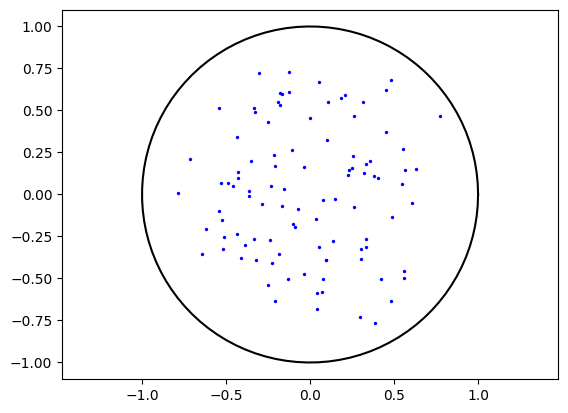

In [8]:
poincare_manifold, poincare_points = hyperbolic_manifold.stereographic(hyperbolic_points)

plt.scatter(poincare_points[:, 0].detach().numpy(), poincare_points[:, 1].detach().numpy(), color="blue", s=2)
plt.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), color="k")
plt.axis("equal")
plt.show()

Manify implements `dist` methods we can use to compute distances between two points on the manifold. They broadcast in
the same way as you might expect in PyTorch (or your favorite tensor library):

In [9]:
hyperbolic_dists = hyperbolic_manifold.dist(hyperbolic_points[:8], hyperbolic_points[-4:])
hyperbolic_dists

tensor([[0.1615, 2.0956, 1.3884, 0.6726],
        [2.3937, 2.5836, 1.0624, 2.7895],
        [2.8103, 3.2496, 1.7002, 3.2385],
        [0.6917, 2.8099, 2.1660, 0.8168],
        [2.5606, 2.2400, 1.0642, 2.8971],
        [0.8785, 1.2488, 1.0086, 1.0203],
        [3.3514, 3.4192, 1.9538, 3.7368],
        [1.6859, 1.3773, 0.3105, 1.9934]], grad_fn=<MulBackward0>)

Notice that if we do the same thing with the Poincaré disk model, we get the same result. This is because the two models
are isometric (i.e. they preserve distances). This is also true for the sphere and stereographic sphere.

In [13]:
poincare_dists = poincare_manifold.dist(poincare_points[:8], poincare_points[-4:])
print(f"Total absolute deviation between distances: {(hyperbolic_dists - poincare_dists).abs().sum()}")
poincare_dists

Total absolute deviation between distances: 1.379847526550293e-05


tensor([[0.1615, 2.0956, 1.3884, 0.6726],
        [2.3937, 2.5836, 1.0624, 2.7895],
        [2.8103, 3.2496, 1.7002, 3.2385],
        [0.6917, 2.8099, 2.1660, 0.8168],
        [2.5606, 2.2400, 1.0642, 2.8971],
        [0.8785, 1.2488, 1.0086, 1.0203],
        [3.3514, 3.4192, 1.9538, 3.7368],
        [1.6859, 1.3773, 0.3105, 1.9934]], grad_fn=<MulBackward1>)

Note that each manifold is equipped with a `manifold` attribute, which is a reference to its base Geoopt class. So for
instance, if we prefer to use the `random_normal` method there (which is implemented for this particular manifold),
we can do so like this:

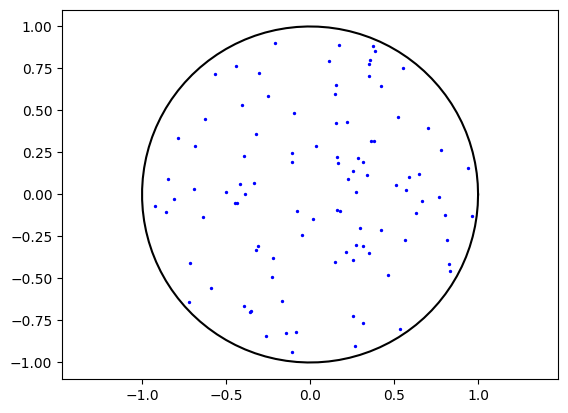

In [16]:
poincare_points_geoopt = poincare_manifold.manifold.random_normal((100, 2))

plt.scatter(
    poincare_points_geoopt[:, 0].detach().numpy(), poincare_points_geoopt[:, 1].detach().numpy(), s=2, color="blue"
)
plt.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), color="k")
plt.axis("equal")
plt.show()

### Product manifolds

Probably the reason you're here is because you want to work with product manifolds, since the basic manifold classes
are available in a number of other popular libraries. The `ProductManifold` class is initialized with a **signature**,
which is a list of (curvature, dimension) tuples. The curvature can be any float, and the dimension any integer. So
for instance, the signature `[(1.0, 2), (0.0, 3), (-1.0, 4)]` would create a product manifold with a 2D sphere,
a 3D Euclidean space, and a 4D hyperbolic space.

In addition the all of the methods available in the `Manifold` class, the `ProductManifold` class also provides a few other methods:
* `parameters`: Returns a list of all scale factors (think curvatures) for each of the manifolds in the product; useful in learnable-curvature settings
* `factorize`: Factorizes a set of points on the product manifold into a list of points on each of the individual manifolds
* `gaussian_mixture`: Samples points from a Gaussian mixture model on the product manifold, useful for benchmarking classifiers and regressors

Let's take a look at the latter two methods in action using the signature we suggested above.

In [17]:
product_manifold = manify.ProductManifold(signature=[(1.0, 2), (0.0, 3), (-1.0, 4)])

If we sample some points from this manifold, we'll find that they have $(2+ 1) + (3) + (4 + 1) = 11$ dimensions: all
non-Euclidean manifolds have an extra ambient dimension, whereas Euclidean manifolds (curvature 0) do not.

In [18]:
product_points = product_manifold.sample(n_samples=1000)
print(f"Sampled points shape: {product_points.shape}")

Sampled points shape: torch.Size([1000, 11])


If you would like to work with each component manifold's coordinates separately, the `factorize` method will return a
list of tensors in each manifold's coordinates:

In [19]:
product_points_factorized = product_manifold.factorize(X=product_points)
print(f"Factorized points shape: {[p.shape for p in product_points_factorized]}")

Factorized points shape: [torch.Size([1000, 3]), torch.Size([1000, 3]), torch.Size([1000, 5])]


The product manifold class has a lot of structure to help map between the different component manifolds and embeddings.
To make matters worse, sometimes we need to deal with *intrinsic* dimensions as well (e.g. when sampling covariance) 
matrices!

Here we will print out some of the attributes that help with this bookkeeping.

The `projection_matrix` attribute is especially nice, as right-multiplying a sample by this will add zeros in all of the
ambient dimensions for each component manifold - effectively turning a Gaussian sample into an element of the product
manifold's tangent plane at the origin! We make extensive use of this in all of our sampling methods.

dim2man (Ambient dimension -> Manifold mapping): {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2}
man2dim (Manifold -> Ambient dimension mapping): {0: [0, 1, 2], 1: [3, 4, 5], 2: [6, 7, 8, 9, 10]}
man2intrinsic (Manifold -> Intrinsic dimension mapping): {0: [0, 1], 1: [2, 3, 4], 2: [5, 6, 7, 8]}
man2intrinsic (Manifold -> Ambient dimension mapping): {0: [0, 1], 1: [2, 3, 4], 2: [5, 6, 7, 8]}


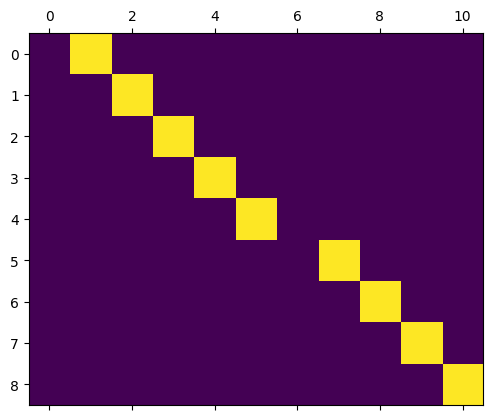

In [20]:
print(f"dim2man (Ambient dimension -> Manifold mapping): {product_manifold.dim2man}")
print(f"man2dim (Manifold -> Ambient dimension mapping): {product_manifold.man2dim}")
print(f"man2intrinsic (Manifold -> Intrinsic dimension mapping): {product_manifold.man2intrinsic}")
print(f"man2intrinsic (Manifold -> Ambient dimension mapping): {product_manifold.man2intrinsic}")

plt.matshow(product_manifold.projection_matrix.numpy())
plt.show()

Note that the `P` attribute contains pointers to each of the individual manifolds:

In [21]:
print(product_manifold.P)

[<manify.manifolds.Manifold object at 0x3450f7bc0>, <manify.manifolds.Manifold object at 0x34727d040>, <manify.manifolds.Manifold object at 0x347268cb0>]


Notice, additionally, that nothing is stopping us from having a single component in our signature. This essentially
means that you can always use the `ProductManifold` class, which in fact is what we recommend you do.

In [22]:
hyperbolic_pseudoproduct_manifold = manify.ProductManifold(signature=[(-1.0, 2)])

One neat thing that the `ProductManifold` class supports is sampling from Gaussian mixtures. This is really useful if
you want to benchmark some classifiers or regressors, among other things. Let's take a look at some points we've
sampled from a Gaussian mixture model on the product manifold.

The seeds are not set for these cells, so feel free to run them multiple times to get a sense for how the points change.

Of course, in higher dimensions or in product manifolds, you would generally expect the points to be more separable
than what you see in these cartoons. Nonetheless, these are honest-to-God samples from Gaussian mixture models on the
Poincaré disk, and it's helpful to have some context about what they tend to look like.

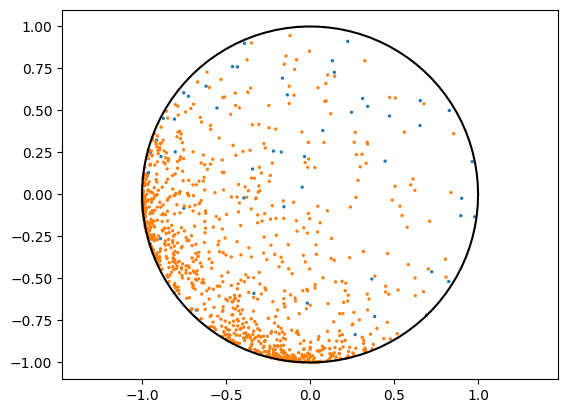

In [23]:
X, y = hyperbolic_pseudoproduct_manifold.gaussian_mixture(num_points=1000, num_classes=2)
_, X_poincare = hyperbolic_pseudoproduct_manifold.stereographic(X)

plt.scatter(
    X_poincare[:, 0].detach().numpy(), X_poincare[:, 1].detach().numpy(), c=y, s=2, cmap="tab10", vmin=0, vmax=10
)
plt.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), color="k")
plt.axis("equal")
plt.show()

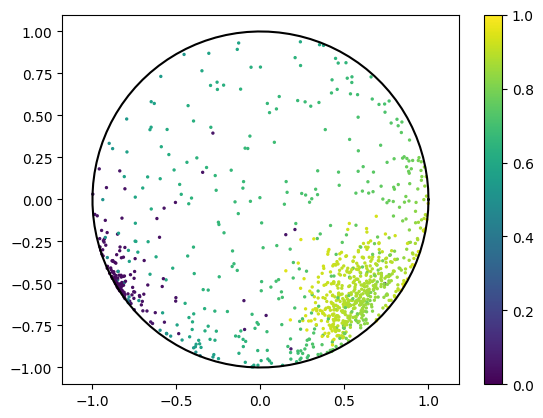

In [24]:
X, y = hyperbolic_pseudoproduct_manifold.gaussian_mixture(num_points=1000, num_classes=3, task="regression")
_, X_poincare = hyperbolic_pseudoproduct_manifold.stereographic(X)

plt.scatter(X_poincare[:, 0].detach().numpy(), X_poincare[:, 1].detach().numpy(), c=y, s=2, cmap="viridis")
plt.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), color="k")
plt.axis("equal")
plt.colorbar()
plt.show()

## Embedders

All embedders in Manify inherit from the `BaseEmbedder` class, which provides a common API for all embedders. All
embedders have the following methods:
* `fit`: Fit the embedder to the data.
* `transform`: Transform the data to the embedded space.
* `fit_transform`: Fit the embedder to the data and transform it in one go.

Not all embedders use the same data types, however! If you have pairwise distances, as you might e.g. when embedding a
graph, you can use the `CoordinateLearning` class; if you have features, you can use the `ProductSpaceVAE` class.
Finally, we have an experimental `SiameseNetwork` class that can use both pairwise distances and features to learn
embeddings.

### Coordinate Learning

Coordinate learning works when you have a matrix of pairwise distances of some sort. Let's use the `load_hf` utility to grab one of the graph datasets from our HuggingFace hub, and then embed it into plain old Euclidean space.

We will use 2D Euclidean space for visualization's sake, but feel free to change the signature - you might find that other signatures do a lot better for embedding these datasets.

In [25]:
_, polblogs_dists, _, polblogs_labels = utils.dataloaders.load_hf("polblogs")
print(polblogs_dists.shape)

torch.Size([1222, 1222])


Because we would like to distinguish between distances and features, the `fit` method of all embedders takes a matrix of features `X` and a matrix of pairwise distances `D`, in that order. Since the coordinate learning embedder does not use features, we can just pass `None` for the `X` argument. 

This syntax is slightly more verbose than simply passing the distance matrix as the only argument, but we believe it is worth it to maintain a consistent interface across all embedder types.

Let's train for 1,000 iterations total. On most computers this should take under a minute, achieving a final D_avg of 0.3438 (which is not very good, honestly, but we are interested more in demonstrations and visualizations than in actual performance here).

In [26]:
euclidean_manifold = manify.ProductManifold(signature=[(0.0, 2)])

coordinate_learning_embedder = manify.CoordinateLearning(pm=euclidean_manifold)
polblogs_embeddings = coordinate_learning_embedder.fit_transform(
    X=None, D=polblogs_dists, burn_in_iterations=100, training_iterations=900
)
print(polblogs_embeddings.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1222, 2])


The coordinate learning method learns a single set of coordinates, so we can use the `transform` method to get them. It does not require any arguments.

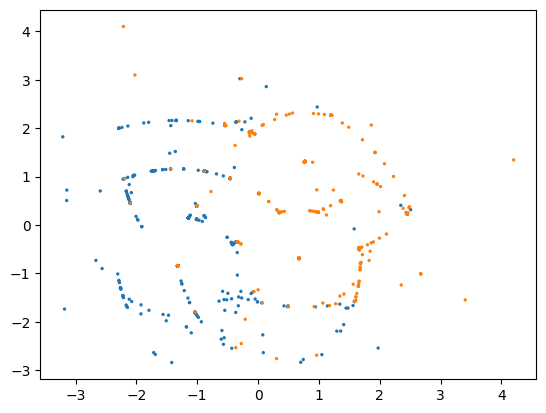

In [27]:
plt.scatter(
    polblogs_embeddings[:, 0].detach().numpy(),
    polblogs_embeddings[:, 1].detach().numpy(),
    c=polblogs_labels.numpy(),
    s=2,
    cmap="tab10",
    vmin=0,
    vmax=9,
)
plt.show()

You can also plot the loss history for all of your embedders like this. In this case, `train_train` refers to the distortion in the distances between elements of the training set and other elements of the training set; this is because `CoordinateLearning` supports non-transductive co-learning of train and test sets, wherein the gradient from the test set to the training set is masked out during training. 

For more details, consult the documentation of the `CoordinateLearning` class at [Manify's documentation](https://manify.readthedocs.io/en/latest/reference/embedders/coordinate_learning/).

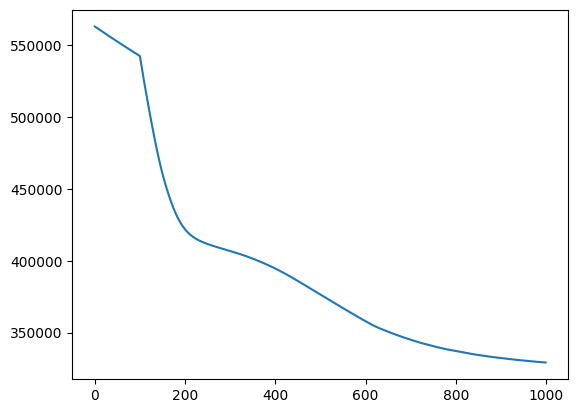

In [28]:
plt.plot(coordinate_learning_embedder.loss_history_["train_train"])
plt.show()

### Product Space VAE

In [29]:
mnist_features, _, _, mnist_labels = utils.dataloaders.load_hf("mnist")
print(mnist_features.shape)

torch.Size([60000, 28, 28])


The `ProductSpaceVAE` embedder requires an encoder and a decoder to be defined. The only constraints are:
* The input to the first layer of the encoder must be equal to the number of features in your data
* The output of the last layer of the decoder must be equal to the number of INTRINSIC dimensions in your product manifold
* The input to the first layer of the decoder must be equal to the number of EXTRINSIC (ambient) dimensions in your product manifold
* The output of the last layer of the encoder must be equal to the number of features in your data

The reason the encoder outputs intrisic dimensions, but the decoder takes extrinsic dimensions as input, has to do with the way that the VAE sampling occurs. For more details, consult the documentation of the `ProductSpaceVAE` class at [Manify's documentation](https://manify.readthedocs.io/en/latest/reference/embedders/vae/).

The following code should also run in under a minute on most computers.

In [30]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2 * euclidean_manifold.dim),  # The INTRINSIC dimension of the manifold
)
decoder = torch.nn.Sequential(
    torch.nn.Linear(euclidean_manifold.ambient_dim, 128),  # The AMBIENT dimension of the manifold
    torch.nn.ReLU(),
    torch.nn.Linear(128, 784),
    torch.nn.Sigmoid(),
)


vae = manify.ProductSpaceVAE(pm=euclidean_manifold, encoder=encoder, decoder=decoder)

mnist_embeddings = vae.fit_transform(
    X=mnist_features.reshape(-1, 784), burn_in_iterations=1, training_iterations=9, batch_size=128
)
print(mnist_embeddings.shape)

  0%|          | 0/600000 [00:00<?, ?it/s]

torch.Size([60000, 2])


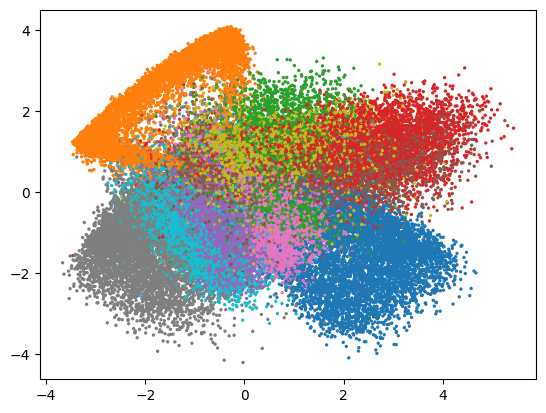

In [31]:
plt.scatter(
    mnist_embeddings[:, 0].detach().numpy(),
    mnist_embeddings[:, 1].detach().numpy(),
    c=mnist_labels.numpy(),
    s=2,
    cmap="tab10",
    vmin=0,
    vmax=9,
)
plt.show()

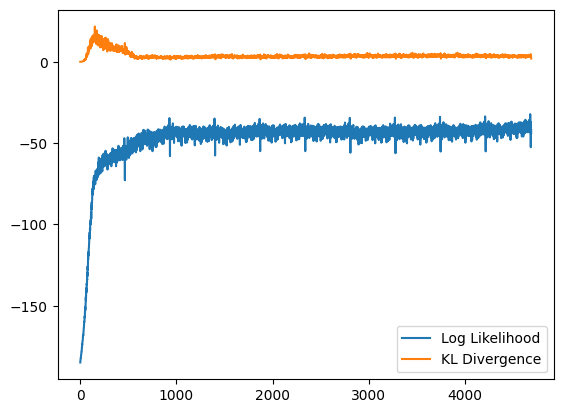

In [32]:
plt.plot(vae.loss_history_["ll"], label="Log Likelihood")
plt.plot(vae.loss_history_["kl"], label="KL Divergence")
plt.legend()
plt.show()

### Siamese Network

(**Note:** This is a fairly experimental embedder, and does not have an accompanying publication. We believe this might be useful in situations where you have both pairwise distances and features, but we haven't tested it extensively yet.)

In [33]:
qiita_features, qiita_dists, _, _ = utils.dataloaders.load_hf("qiita")
print(qiita_features.shape)

torch.Size([7000, 152])


This bit is a little slower, so we're just going to use 500 points for the tutorial:

In [34]:
SUBSAMPLE_QIITA = 500

encoder = torch.nn.Sequential(
    torch.nn.Linear(152, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, euclidean_manifold.dim),
)
decoder = torch.nn.Sequential(torch.nn.Linear(euclidean_manifold.ambient_dim, 64), torch.nn.Linear(64, 152))
siamese_net = manify.SiameseNetwork(pm=euclidean_manifold, encoder=encoder, decoder=decoder, random_state=42)
qiita_embeddings = siamese_net.fit_transform(
    X=qiita_features[:SUBSAMPLE_QIITA],
    D=qiita_dists[:SUBSAMPLE_QIITA, :SUBSAMPLE_QIITA],
    burn_in_iterations=1,
    training_iterations=9,
    batch_size=128,
)

  0%|          | 0/9750 [00:00<?, ?it/s]

We can color our embeddings on the basis of their true distance from some random point. We can see that even in two dimensions with very few iterations, the learned embeddings tend to preserve these distance relationships:

[]

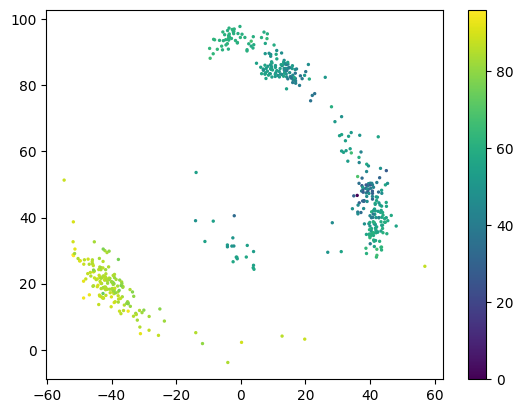

In [35]:
plt.scatter(
    qiita_embeddings[:, 0].detach().numpy(),
    qiita_embeddings[:, 1].detach().numpy(),
    c=qiita_dists[0, :SUBSAMPLE_QIITA].numpy(),
    s=2,
)
plt.colorbar()
plt.plot()

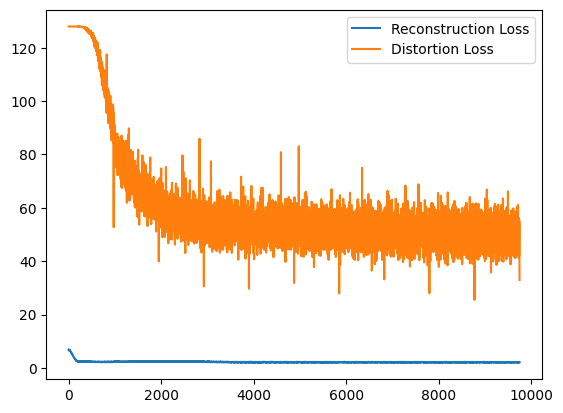

In [36]:
plt.plot(siamese_net.loss_history_["reconstruction"], label="Reconstruction Loss")
plt.plot(siamese_net.loss_history_["distortion"], label="Distortion Loss")
plt.legend()
plt.show()

## Predictors

Like the embedders, all predictors in Manify inherit from the `BasePredictor` class, but they are much more harmonious in terms of their API. All predictors are initialized with a reference to a product manifold (`pm`) and a `task` (`"classification"` or `"regression"`), and have the following methods:
* `fit`: Fit the predictor to the data.
* `predict`: Predict the target variable for the data.
* `fit_predict`: Fit the predictor to the data and predict the target variable in one go
* `score`: Compute the score of the predictor on the data.

Unlike the embedders, none of the predictors require exotic extra arguments for these methods, so they are quite straightforward to use.

### Classification

In [50]:
from sklearn.model_selection import train_test_split

product_manifold = manify.ProductManifold(signature=[(-1.0, 2), (0.0, 2), (1.0, 2)])
X_classification, y_classification = product_manifold.gaussian_mixture(num_points=1000, num_classes=2, seed=2025)

X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=2025
)

In [51]:
for model in [manify.ProductSpaceDT, manify.ProductSpaceRF, manify.ProductSpacePerceptron, manify.ProductSpaceSVM]:
    model_instance = model(pm=product_manifold, task="classification", random_state=2025)
    model_instance.fit(X_train_classification, y_train_classification)
    y_pred = model_instance.predict(X_test_classification)
    accuracy = model_instance.score(X_test_classification, y_test_classification)
    print(f"{model.__name__} Accuracy: {accuracy:.2f}")

ProductSpaceDT Accuracy: 0.90
ProductSpaceRF Accuracy: 0.94
ProductSpacePerceptron Accuracy: 0.45
ProductSpaceSVM Accuracy: 0.93


For $\kappa$-GCNs, we need to make three additional modifications:
* We need to use a stereographic manifold
* We need to pass the `output_dim` argument explicitly to the constructor
* We need to set the learning rate to something reasonably stable, like .001:

In [ ]:
# Convert product_manifold, X_train, and X_test to stereographic coordinates:
product_manifold_stereo, X_train_classification_stereo, X_test_classification_stereo = product_manifold.stereographic(
    X_train_classification, X_test_classification
)

# This part is the same, except for how we construct the KappaGCN instance
kappa_gcn_instance = manify.KappaGCN(pm=product_manifold_stereo, task="classification", random_state=2025, output_dim=2)
kappa_gcn_instance.fit(X_train_classification_stereo, y_train_classification, lr=0.001)
y_pred = kappa_gcn_instance.predict(X_test_classification_stereo)
accuracy = kappa_gcn_instance.score(X_test_classification_stereo, y_test_classification)
print(f"{kappa_gcn_instance.__class__.__name__} Accuracy: {accuracy:.2f}")

  0%|          | 0/2000 [00:00<?, ?it/s]

KappaGCN Accuracy: 0.76


Fun fact: $\kappa$-GCN models also store `loss_history_`, so we can plot that too. This one looks a little wonky, so maybe we should have played around more with the learning rate:

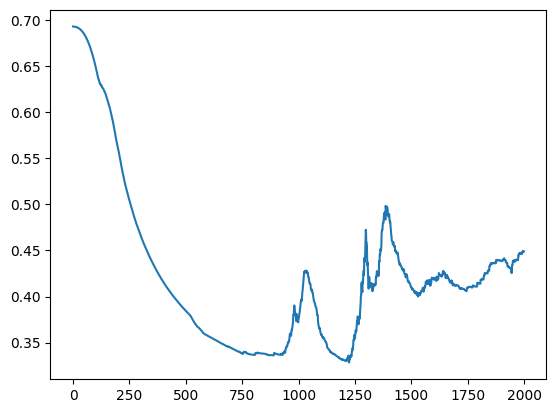

In [53]:
plt.plot(kappa_gcn_instance.loss_history_["train"])
plt.show()

### Regression

And just for kicks, let's repeat the same thing for regression. This isn't implemented for Perceptrons and SVMs yet (in fact, it's never been described at all in the literature), but we can use the other predictors just fine. Notice that `output_dim` must be set to 1 for the $\kappa$-GCN (although in theory you can do multioutput regression this way as well).

In [54]:
# Get the points again - this time as regression targets
X_regression, y_regression = product_manifold.gaussian_mixture(
    num_points=1000, num_classes=2, seed=2025, task="regression"
)
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=2025
)

# Re-benchmark DTs and RFs
for model in [manify.ProductSpaceDT, manify.ProductSpaceRF]:
    model_instance = model(pm=product_manifold, task="regression", random_state=2025)
    model_instance.fit(X_train_regression, y_train_regression)
    y_pred = model_instance.predict(X_test_regression)
    accuracy = model_instance.score(X_test_regression, y_test_regression)
    print(f"{model.__name__} MSE: {accuracy:.4f}")

# Repeat conversion to stereographic coordinates and KappaGCN fitting
product_manifold_stereo, X_train_regression_stereo, X_test_regression_stereo = product_manifold.stereographic(
    X_train_regression, X_test_regression
)

# Evaluate Kappa-GCN
kappa_gcn_instance = manify.KappaGCN(pm=product_manifold_stereo, task="regression", random_state=2025, output_dim=1)
kappa_gcn_instance.fit(X_train_regression_stereo, y_train_regression, lr=0.001)
y_pred = kappa_gcn_instance.predict(X_test_regression_stereo)
accuracy = kappa_gcn_instance.score(X_test_regression_stereo, y_test_regression)
print(f"{kappa_gcn_instance.__class__.__name__} MSE: {accuracy:.4f}")

ProductSpaceDT MSE: 0.0280
ProductSpaceRF MSE: 0.0168


  0%|          | 0/2000 [00:00<?, ?it/s]

KappaGCN MSE: 0.0218


## End-to-end example (pipeline)

Now that we've seen all of the components, let's actually put together an end-to-end example. Here, we'll be embedding the Polblogs dataset from before into a product manifold, and classifying it using a product space decision tree.

(You may recognize this as the "Quick Example" subsection of the Github README, but we include it here for completeness.)

In [55]:
# Load Polblogs graph from HuggingFace
_, dists, _, labels = manify.utils.dataloaders.load_hf("polblogs")

# Create an S^4 x H^4 product manifold
pm = manify.ProductManifold(signature=[(1.0, 4), (-1.0, 4)])

# Learn embeddings (Gu et al (2018) method)
embedder = manify.CoordinateLearning(pm=pm)
X_embedded = embedder.fit_transform(X=None, D=dists, burn_in_iterations=200, training_iterations=800)

# Train and evaluate classifier (Chlenski et al (2025) method)
X_train, X_test, y_train, y_test = train_test_split(X_embedded, labels)
model = manify.ProductSpaceDT(pm=pm, max_depth=3, task="classification")
model.fit(X_train, y_train)
print(f"Decision Tree accuracy on Polblogs classification: {model.score(X_test, y_test):.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Decision Tree accuracy on Polblogs classification: 0.92


# Curvature estimation

[Curvature estimation tutorial coming soon!]

# Clustering

[Clustering tutorial coming soon!]